In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt  

In [226]:
# 自动识别出最接近量表的图片并分割
def cutPicOld(path):
    # 0 读入原始照片
    img = cv2.imread(path,0)
    # plt.imshow(img,cmap = 'gray')
    # plt.show()
    
    # 1 水表图形分割
    aim = img[:1000, 700:1000]
    # aim = img
    print("分割后图片为：")
    plt.imshow(aim,cmap = 'gray')
    plt.show()
    return aim

In [227]:
def preProcess(aim, contType = "sim"):
    # 2. 预处理
    # 2.1 直方图均衡化提高度对比度

    # 查看原始直方图
    # plt.hist(aim.ravel(),256,[0,256]);  
    # plt.show() 

    # 先平滑后均衡
    kernel = np.ones((5,5),np.float32)/25
    # dst = cv2.filter2D(aim,-1,kernel)
    dst = cv2.GaussianBlur(aim,(5,5),0)

    equ = cv2.equalizeHist(dst)  
#     print("平滑后图片为：")
#     plt.subplot(121),plt.imshow(aim,cmap = 'gray'),plt.title('Original')
#     plt.xticks([]), plt.yticks([])
#     plt.subplot(122),plt.imshow(equ,cmap = 'gray'),plt.title('Averaging')
#     plt.xticks([]), plt.yticks([])
#     plt.show()

    # 查看平滑后直方图
    # plt.hist(equ.ravel(),256,[0,256]);  
    # plt.show() 
    
    # 2.2 闭运算：先膨胀后腐蚀, 填充前景物体中的小洞
    closing = cv2.morphologyEx(equ, cv2.MORPH_CLOSE, kernel)

    # plt.subplot(121),plt.imshow(equ, cmap = 'gray')  
    # plt.title('Original Image'), plt.xticks([]), plt.yticks([])  
    # plt.subplot(122),plt.imshow(closing, cmap = 'gray')  
    # plt.title('Closing Image'), plt.xticks([]), plt.yticks([])  
    # plt.show()  
    
    # 2.3 图像去噪
    dst_de = cv2.fastNlMeansDenoising(closing, None, 50, 7, 21)
#     print("去除噪点后图片为：")
#     plt.subplot(121),plt.imshow(equ, cmap = 'gray')  
#     plt.title('Original Image'), plt.xticks([]), plt.yticks([])  
#     plt.subplot(122),plt.imshow(dst_de, cmap = 'gray')  
#     plt.title('Denoise Image'), plt.xticks([]), plt.yticks([])  
#     plt.show() 
    
    # 2.4 二值化
    ret,thresh = cv2.threshold(dst_de,127,255,0)
#     print("二值化后图片为：")
#     plt.subplot(121),plt.imshow(equ, cmap = 'gray')  
#     plt.title('Original Image'), plt.xticks([]), plt.yticks([])  
#     plt.subplot(122),plt.imshow(thresh, cmap = 'gray')  
#     plt.title('Thresh Image'), plt.xticks([]), plt.yticks([])  
#     plt.show() 
    
    # 2.5 Canny 边缘检测
    edges = cv2.Canny(thresh,50,150) 
#     print("边缘检测结果为：")
#     plt.subplot(121),plt.imshow(equ, cmap = 'gray')  
#     plt.title('Original Image'), plt.xticks([]), plt.yticks([])  
#     plt.subplot(122),plt.imshow(edges, cmap = 'gray')  
#     plt.title('Edge Image'), plt.xticks([]), plt.yticks([])  
#     plt.show()  
    
    # 2.6 轮廓提取
    ret,thresh = cv2.threshold(dst_de,127,255,0)
    
    if contType == "sim":
        contour, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    else:
        contour, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
#     print("水表轮廓为：")
#     plt.subplot(121),plt.imshow(equ, cmap = 'gray')  
#     plt.title('Original Image'), plt.xticks([]), plt.yticks([])  

#     color = cv2.cvtColor(equ, cv2.COLOR_GRAY2BGR)
#     result = cv2.drawContours(color, contour, -1, (0,255,0), 2) #轮廓用绿色绘制
#     # result[:, 95:105] = (0,0,255)
#     # result[:, 125:135] = (0,0,255)
#     result[:, 145:155] = (0,0,255)

#     plt.subplot(122),plt.imshow(result)  
#     plt.title('Contours Image'), plt.xticks([]), plt.yticks([])  
#     plt.show()  
    
    return equ, contour

In [228]:
def getWaterLine(equ, contour):
    # 3 提取刻度位置

    # 3.1 找出量表轮廓位置: max s.t. contour[0].size
    maxA = 0
    maxS = contour[0].size

    for i in range(0, len(contour)):
        if (contour[i].size > maxS):
            maxA = i
            maxS = contour[i].size 
    # print(maxA, maxS)  

    # 3.2 分割出量表区域 [st : en]
    st = 0
    while (contour[maxA][st][0, 1] < len(equ) / 3 * 2):
        st += 1;
    
    en = st + 1
    while (contour[maxA][en][0, 1] > len(equ) / 3 * 2):
        en += 1; 
    
    # print(st, en)  


    # 3.3 找出最低端零刻度
    Index_0 = 0
    Height_0 = 0
    for i in range(st, en):
        if (contour[maxA][i][0, 1] > Height_0):
            Index_0 = i
            Height_0 = contour[maxA][i][0, 1]

    # print(contour[maxA][Index_0]) # 零刻度位置

    # 3.4 记录零刻度边界
    arr_zero = []

    left_0 = contour[maxA][Index_0][0, 0]
    right_0 = left_0

    for i in range(st, en):
        if (abs(contour[maxA][i][0, 1] - Height_0) < 5):
            arr_zero.append(contour[maxA][i])
            if (contour[maxA][i][0, 0] < left_0):
                left_0 = contour[maxA][i][0, 0]
            if (contour[maxA][i][0, 0] > right_0):
                right_0 = contour[maxA][i][0, 0]    
        
    print("zero is in :", left_0, right_0) # 零刻度坐标
    
    plt.imshow(equ[Height_0-10:Height_0+10, left_0-20:right_0+20], cmap = 'gray')  
    plt.title(' Zero Pos'), plt.xticks([]), plt.yticks([])  
    plt.show() 
    
    # 3.5 记录刻度位置数组
    arr_peak = []
    right_bound = left_0 # 水位线左边界
    left_bound = right_0 # 水位线右坐标

    for i in range(st, en):
        i_x = contour[maxA][i][0, 0]
    
        if (i_x > right_bound):
            right_bound = i_x
            
        if (i_x < left_bound):
            left_bound = i_x
            
        peak = True
    
        j = 1
        if (i_x <= contour[maxA][i - j][0, 0]):
            while (i_x == contour[maxA][i - j][0, 0]):
                j += 1
            if (i_x < contour[maxA][i - j][0, 0]):
                peak = False
    
        if (not peak):
            continue
    
        j = 1
        if (i_x <= contour[maxA][i + j][0, 0]):
            while (i_x == contour[maxA][i + j][0, 0]):
                j += 1
            if (i_x < contour[maxA][i + j][0, 0]):
                peak = False
    
        if peak and abs(left_0 - contour[maxA][i][0, 0]) < 10:
            arr_peak.append(contour[maxA][i][0])
            # arr_peak.append(i)
        
        # print(arr_peak) # 刻度坐标 

    # 3.6 计算单位刻度长度
    div = 0
    num = 0
    pre = arr_peak[0][1]
    for i in range(1, len(arr_peak)):
        if abs(arr_peak[i][1] - pre) > 5:
            div += (arr_peak[i][1] - pre)
            num += 1
        pre = arr_peak[i][1]

    lengthPer = div / num # 单位刻度
    # print(lengthPer)
    
    # 3.7 获得轮廓转折点
    # print(left_bound) # 刻度右边界
    rub = en

    for i in range(en, len(contour[maxA])):
        if(contour[maxA][i][0, 0] - right_bound) > 10:
            # print(contour[maxA][i])
            rub = i
            break
        
    # 3.7 寻找水位线
    waterLine = contour[maxA][rub][0, 1]
    # print(waterLine)

    # for i in range(rub, len(contour[maxA]) - 1):
    #     if (contour[maxA][i][0, 1] < waterLine):
    #         # print(contour[maxA][i])
    #         waterLine = contour[maxA][i][0, 1]   
    # print(waterLine)

    # 3.8 计算当前水位
    print("水位线坐标为：[",waterLine, ",", left_bound+700, "] 到 [",waterLine, ",", right_bound+700, "]")
    print("当前水位为：", (Height_0 - waterLine) / (lengthPer * 5))

In [229]:
# 基于轮廓形状找出对称连续线段
def findContourByShape(leftContour, rightContour):
    # ============== 找出左右连续线段 ======================
    leftPos = 0
    leftSize = len(leftContour)
    
    rightPos = 0
    rightSize = len(rightContour)
    
    # 1 扫描左侧轮廓中的连续线段
    leftBlock = []
    for w in range(0, 200):
        # 1.1 基于点的高度进行分块
        w2 = w * 5
        block = []
        while (leftPos < leftSize and leftContour[leftPos][0, 1] < w2 + 5):
            if leftContour[leftPos][0, 1] >= w2:
                block.append(leftContour[leftPos])
            leftPos += 1
            
        # 1.2 检查同一高度block中是否存在连续线段
        conNum = 0
        maxConLen = 0
        pre = 0
        block.sort(key=takeFirst)
        for arr in block:
            if (arr[0, 0] - pre) < 5:
                conNum += 1
                maxConLen = max(maxConLen, conNum)
            else:
                conNum = 0
            pre = arr[0, 0]
            
        # 1.3 保存连续线段
        if maxConLen > 15:
        # if len(block) > 4:
            leftBlock.append(block)
        if (leftPos >= leftSize):
            break
    
    # 2 扫描右侧轮廓中的连续线段
    rightBlock = []
    for w in range(0, 200):
        # 2.1 基于点的高度进行分块
        w2 = w * 5
        block = []
        while (rightPos < rightSize and rightContour[rightPos][0, 1] < w2 + 5):
            if rightContour[rightPos][0, 1] >= w2:
                block.append(rightContour[rightPos])
            rightPos += 1
            
        # 2.2 检查同一高度block中是否存在连续线段
        conNum = 0
        maxConLen = 0
        pre = 0
        block.sort(key=takeFirst)
        for arr in block:
            if (arr[0, 0] - pre) < 5:
                conNum += 1
                maxConLen = max(maxConLen, conNum)
            else:
                conNum = 0
            pre = arr[0, 0]
            
        # 2.3 保存连续线段    
        if maxConLen > 15:
            rightBlock.append(block)
        if (rightPos >= rightSize):
            break
     
    # 返回图块中对称的连续线段数
    print(len(leftBlock), len(rightBlock))
    symNum = min(len(leftBlock), len(rightBlock))
    
    return symNum

In [230]:
# 排序设定函数
def takeFirst(elem):
    return elem[0, 0]

def takeSecond(elem):
    return elem[0, 1]

# 自动识别出最接近量表的图片并分割
def cutPic(path):
    # 0 读入原始照片
    img = cv2.imread(path,0)
    
    # 0.2 照片尺寸
    high = len(img)
    wid = img[0].size
    
    # 1 水表图形分割
    windowSize = 40
    print("预设的滑动窗口尺寸为：", windowSize)
    
    windowNum = int((wid - 300) / windowSize)
    print("图片共分割为",windowNum,"个带扫描图块")
    
    maxSym = 0
    maxWindow = 0
    print("开始对图片进行自动滑动窗口扫描：")
    
    for i in range(0, windowNum):
        bias = i * windowSize
        
        aim = img[0:1000, bias:bias+300]
        print("待扫描图块范围为：[0:1000, ",bias,":",bias+300,"]")
        
        # 1 提取轮廓
        equ, contour = preProcess(aim, "none")
        
        # ================= 2 计算当前图例中最大轮廓面积 =======================
        maxA = 0
        maxIn = 0
        for j in range(0, len(contour)):
            arr = contour[j]
            area = cv2.contourArea(arr)
            if area > maxA:
                maxA = area
                maxIn = j
                
        print("当前图块的最大轮廓面积为：", maxA)
        if maxA < 150000:
            print("轮廓面积过小，跳过当前窗口。")
            continue
        
         # ================= 3 划分左右轮廓 =================
        midWid = wid / 2
        
        leftContour = []
        rightContour = []
        
        # 开始划分
        for arr in contour[maxIn]:
            if arr[0, 0] <= 150:
                leftContour.append(arr)
            else:
                rightContour.append(arr)
        
        # ================= 4 按照高度排序 =================
        leftContour.sort(key=takeSecond)
        rightContour.sort(key=takeSecond)
        
        leftPos = 0
        leftSize = len(leftContour)
    
        rightPos = 0
        rightSize = len(rightContour)
        
        # ================= 5 计算对称点数量 =================
        symNum = 0
        
        # 方法1：基于形状进行计算
        # 用时最少，准确率一般
        # symNum = findContourByShape(leftContour, rightContour)
        
        # 方法2：穷举法
        # 用时最多，准确率最高
        for a1 in range(0, leftSize):
            for a2 in range(0, rightSize):
                 if abs(leftContour[a1][0, 1] - rightContour[a2][0, 1]) < 3:
                        if abs(abs(leftContour[a1][0, 0] - 150) - abs(rightContour[a2][0, 0] - 150)) < 30:
                            symNum += 1
    
        # 方法3：顺序法
        # 用时中等，准确率较好
        ''' 
        leftPos = 0
        rightPos = 0
        while leftPos < leftSize and rightPos < rightSize :
            if abs(leftContour[leftPos][0, 1] - rightContour[rightPos][0, 1]) < 10:
                if abs(leftContour[leftPos][0, 0] - 150) < 20 and abs(rightContour[rightPos][0, 0] - 150) < 20:
                    print(leftContour[leftPos], ":", rightContour[rightPos])
                    symNum += 1   
            if (leftContour[leftPos][0, 1] < rightContour[rightPos][0, 1]):
                leftPos += 1
            else:
                rightPos += 1
        '''
        print("该图块对称点个数为：", symNum)

        if symNum > maxSym:
            maxSym = symNum
            maxWindow = i
            # print(maxSym, symNum, i)
    
    print("自动识别得到的与水表最近似的图块为：")
    
    bias = maxWindow * windowSize
    aim = img[:1000, bias:bias+300]
    equ, contour = preProcess(aim)
    
    plt.subplot(121),plt.imshow(aim, cmap = 'gray')  
    plt.title('Cut Image'), plt.xticks([]), plt.yticks([])
    
    color = cv2.cvtColor(equ, cv2.COLOR_GRAY2BGR)
    result = cv2.drawContours(color, contour, -1, (0,255,0), 2) #轮廓用绿色绘制

    plt.subplot(122),plt.imshow(result)  
    plt.title('Contours Image'), plt.xticks([]), plt.yticks([])  
    plt.show() 

    return aim

In [233]:
def run():
    path = input("请输入待识别图像路径：")
    # path = "sample8.jpg"
    aim = cutPic(path)
    # print("水位轮廓为：")
    equ, contour = preProcess(aim)
    getWaterLine(equ, contour)

请输入待识别图像路径：sample8.jpg
预设的滑动窗口尺寸为： 40
图片共分割为 40 个带扫描图块
开始对图片进行自动滑动窗口扫描：
待扫描图块范围为：[0:1000,  0 : 300 ]
当前图块的最大轮廓面积为： 118025.0
轮廓面积过小，跳过当前窗口。
待扫描图块范围为：[0:1000,  40 : 340 ]
当前图块的最大轮廓面积为： 122457.5
轮廓面积过小，跳过当前窗口。
待扫描图块范围为：[0:1000,  80 : 380 ]
当前图块的最大轮廓面积为： 125442.5
轮廓面积过小，跳过当前窗口。
待扫描图块范围为：[0:1000,  120 : 420 ]
当前图块的最大轮廓面积为： 128261.5
轮廓面积过小，跳过当前窗口。
待扫描图块范围为：[0:1000,  160 : 460 ]
当前图块的最大轮廓面积为： 119200.0
轮廓面积过小，跳过当前窗口。
待扫描图块范围为：[0:1000,  200 : 500 ]
当前图块的最大轮廓面积为： 115940.5
轮廓面积过小，跳过当前窗口。
待扫描图块范围为：[0:1000,  240 : 540 ]
当前图块的最大轮廓面积为： 108427.5
轮廓面积过小，跳过当前窗口。
待扫描图块范围为：[0:1000,  280 : 580 ]
当前图块的最大轮廓面积为： 101311.5
轮廓面积过小，跳过当前窗口。
待扫描图块范围为：[0:1000,  320 : 620 ]
当前图块的最大轮廓面积为： 95438.5
轮廓面积过小，跳过当前窗口。
待扫描图块范围为：[0:1000,  360 : 660 ]
当前图块的最大轮廓面积为： 104789.5
轮廓面积过小，跳过当前窗口。
待扫描图块范围为：[0:1000,  400 : 700 ]
当前图块的最大轮廓面积为： 118850.0
轮廓面积过小，跳过当前窗口。
待扫描图块范围为：[0:1000,  440 : 740 ]
当前图块的最大轮廓面积为： 130686.5
轮廓面积过小，跳过当前窗口。
待扫描图块范围为：[0:1000,  480 : 780 ]
当前图块的最大轮廓面积为： 129062.5
轮廓面积过小，跳过当前窗口。
待扫描图块范围为：[0:1000,  520 : 820 ]
当前图块的

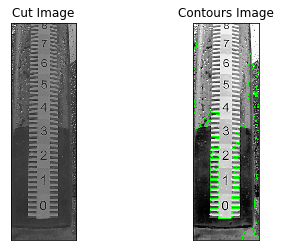

zero is in : 114 176


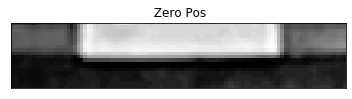

水位线坐标为：[ 475 , 776 ] 到 [ 475 , 913 ]
当前水位为： 5.294915254237289


In [234]:
run()

水表轮廓为：


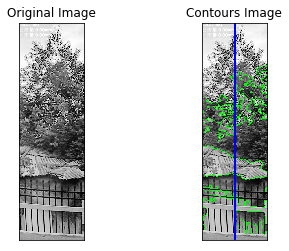

103664.5
水表轮廓为：


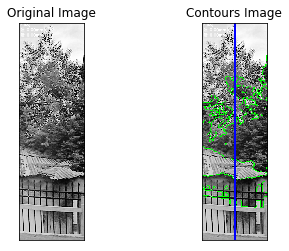

106939.5
水表轮廓为：


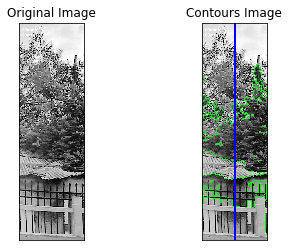

114946.5
水表轮廓为：


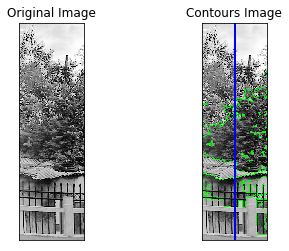

116975.5
水表轮廓为：


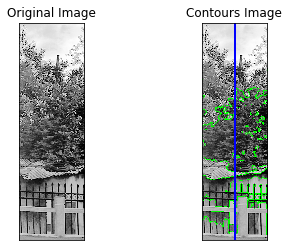

110596.0
水表轮廓为：


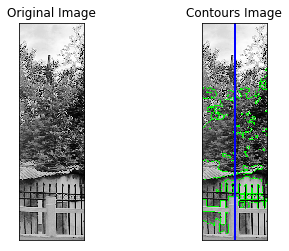

101451.0
水表轮廓为：


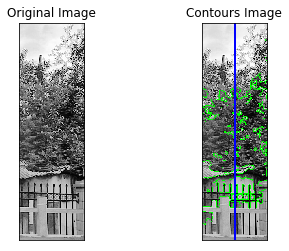

98301.0
水表轮廓为：


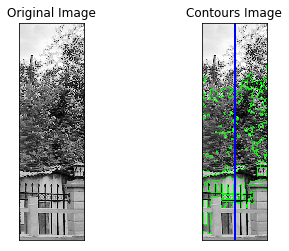

94311.5
水表轮廓为：


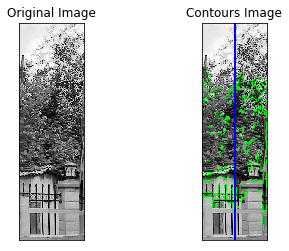

92135.5
水表轮廓为：


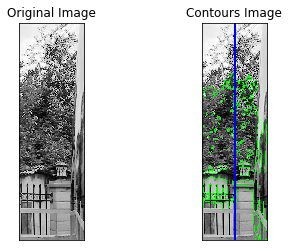

99701.0
水表轮廓为：


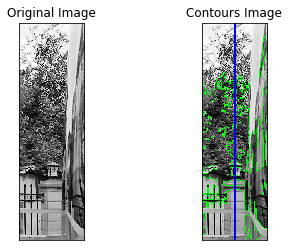

105087.5
水表轮廓为：


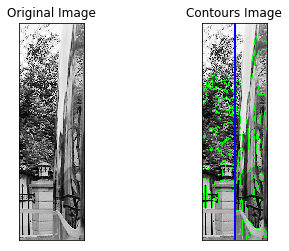

113062.0
水表轮廓为：


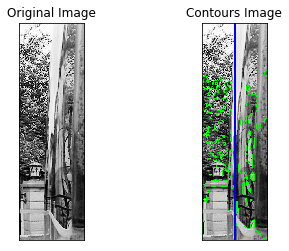

126310.5
水表轮廓为：


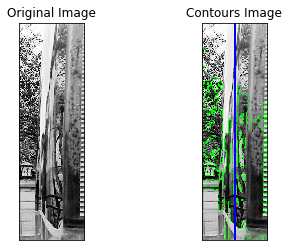

130599.5
水表轮廓为：


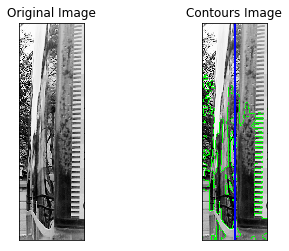

149090.0
水表轮廓为：


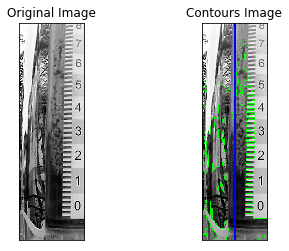

155528.5
25729 25729 15
25729
水表轮廓为：


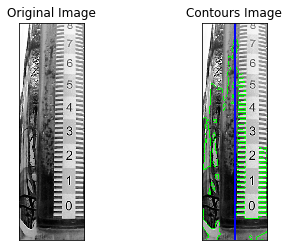

153701.0
14922
水表轮廓为：


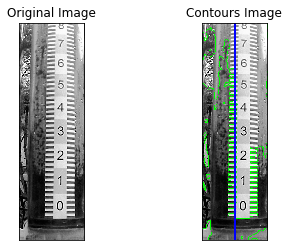

151994.5
19590
水表轮廓为：


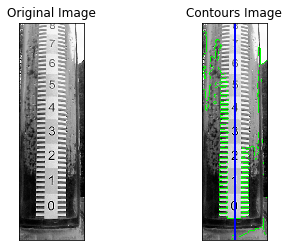

151819.5
42301 42301 18
42301
水表轮廓为：


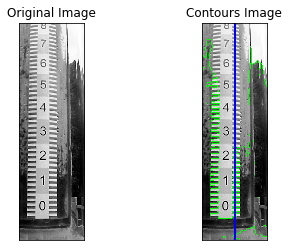

150598.0
22105
水表轮廓为：


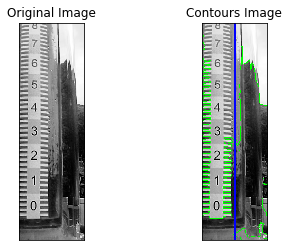

154143.5
15534
水表轮廓为：


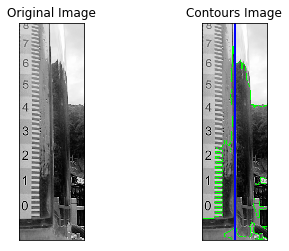

149696.0
水表轮廓为：


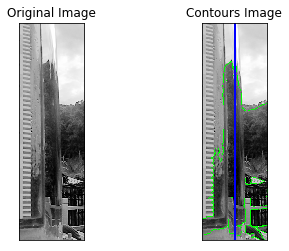

138282.5
水表轮廓为：


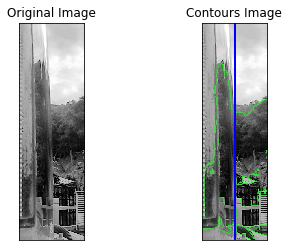

126077.0
水表轮廓为：


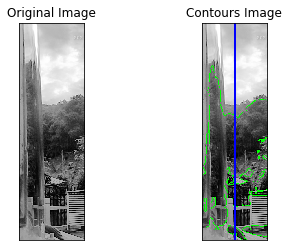

116985.0
水表轮廓为：


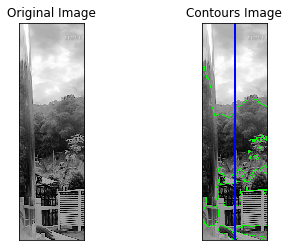

111563.5
水表轮廓为：


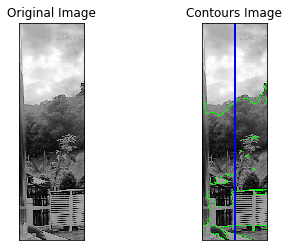

112171.0
水表轮廓为：


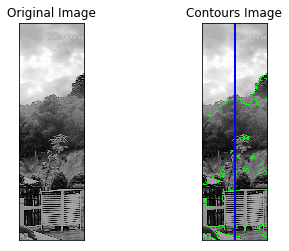

107128.0
水表轮廓为：


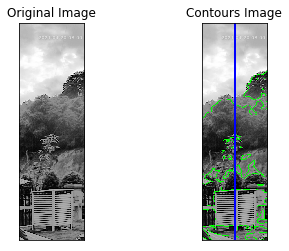

105841.5
水表轮廓为：


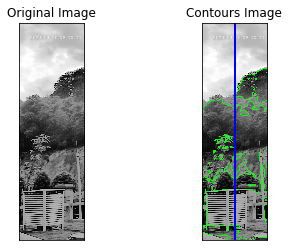

99537.5
水表轮廓为：


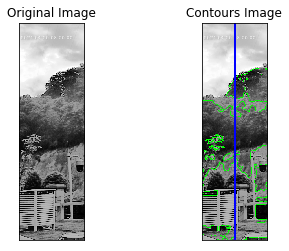

95874.0
水表轮廓为：


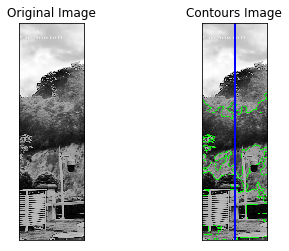

117796.5
水表轮廓为：


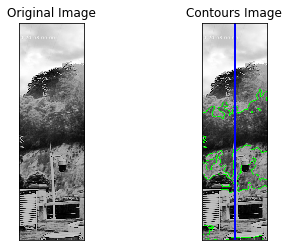

115720.5
水表轮廓为：


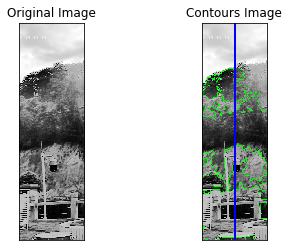

94894.5
水表轮廓为：


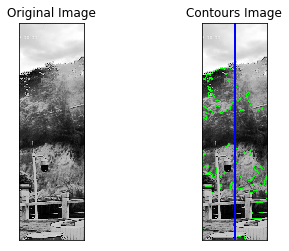

97464.5
水表轮廓为：


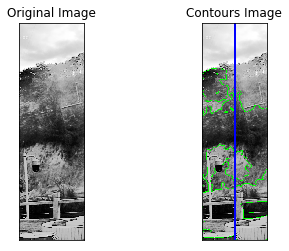

100250.0
水表轮廓为：


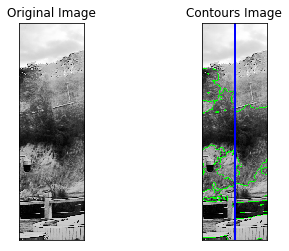

99642.5
水表轮廓为：


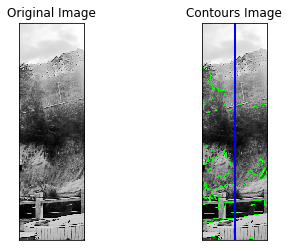

104849.0
水表轮廓为：


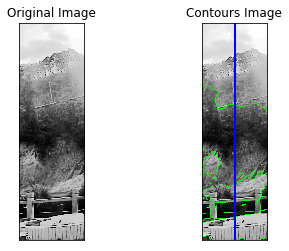

109874.0
水表轮廓为：


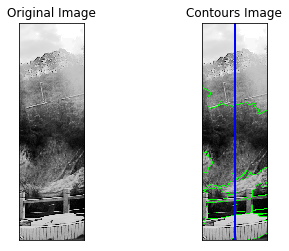

113192.0
18
水表轮廓为：


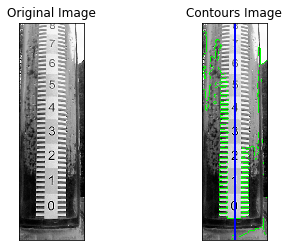

In [219]:

# 进行动态取样
for i in range(0, windowNum):  

    
    
        
    # ================= 计算左右轮廓面积 =================    
    # leftContour = np.array(leftContour)
    # rightContour = np.array(rightContour)
    # leftArea = cv2.contourArea(leftContour)
    # rightArea = cv2.contourArea(rightContour)
    print(symNum)
    
    # ================= 绘制最小外接矩形 =================
    # max_rect = cv2.minAreaRect(contour[maxIn])
    # max_box = cv2.boxPoints(max_rect)
    # max_box = np.int0(max_box)

print(maxWindow)
bias = maxWindow * windowSize
aim = img[:1000, bias:bias+300]
equ, contour = preProcess(aim)

In [15]:
contour[maxIn].size

690

分割后图片为：


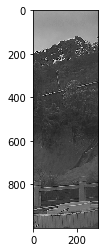

水表轮廓为：


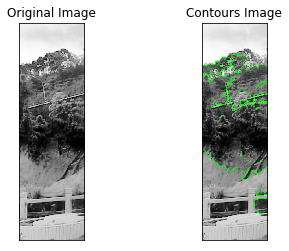

In [9]:
path = "sample8.jpg"

img = cv2.imread(path,0)
# aim = img[:1000, 0:300]

print("分割后图片为：")
plt.imshow(aim,cmap = 'gray')
plt.show()

equ, contour = preProcess(aim)

In [10]:
for arr in contour:
    print(arr.size)

8
20
16
20
690
20
20
24
106
54
16
982
122
60
28
60
40
500
396


In [11]:
len(contour)

19

水表轮廓为：


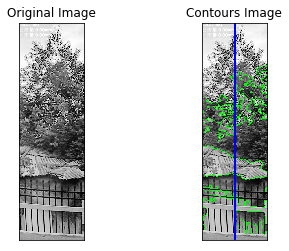

103664.5
水表轮廓为：


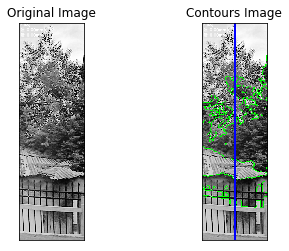

106939.5
水表轮廓为：


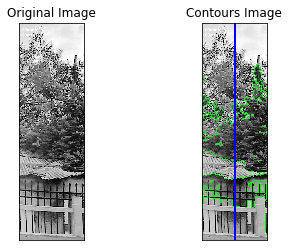

114946.5
水表轮廓为：


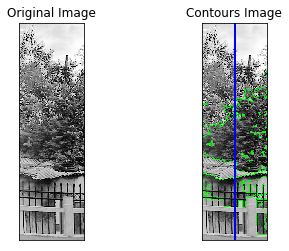

116975.5
水表轮廓为：


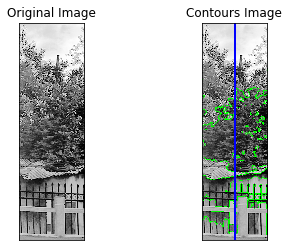

110596.0
水表轮廓为：


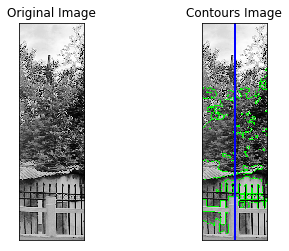

101451.0
水表轮廓为：


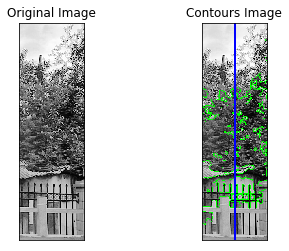

98301.0
水表轮廓为：


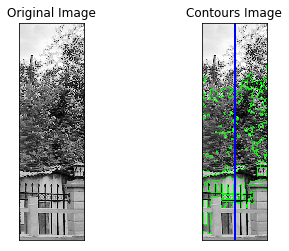

94311.5
水表轮廓为：


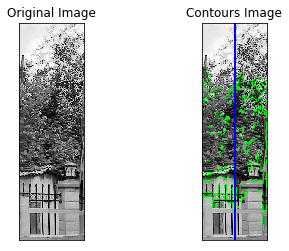

92135.5
水表轮廓为：


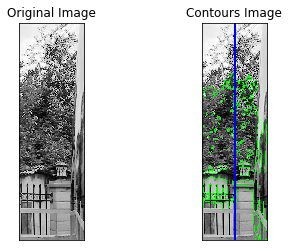

99701.0
水表轮廓为：


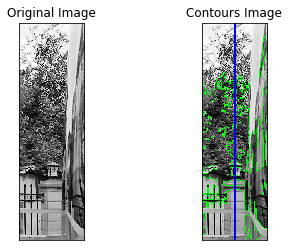

105087.5
水表轮廓为：


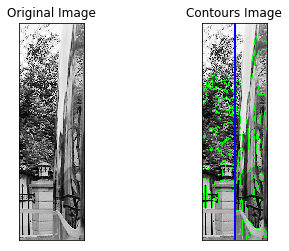

113062.0
水表轮廓为：


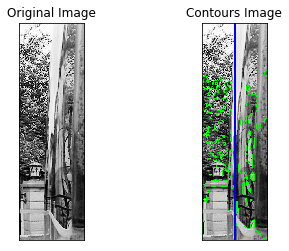

126310.5
水表轮廓为：


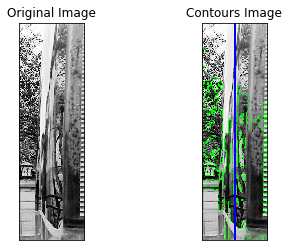

130599.5
水表轮廓为：


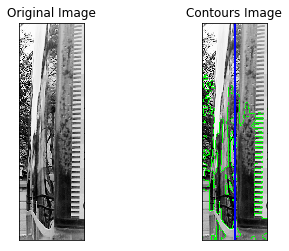

149090.0
水表轮廓为：


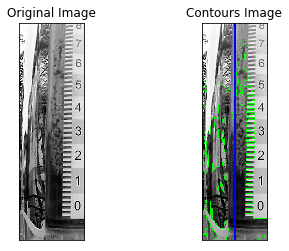

155528.5
25729 25729 15
25729
水表轮廓为：


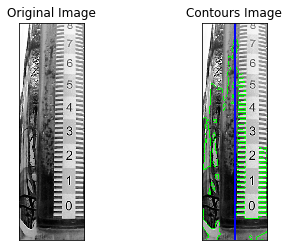

153701.0
14922
水表轮廓为：


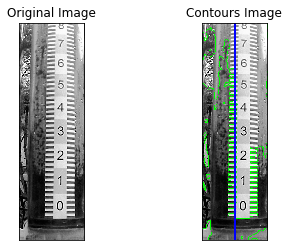

151994.5
19590
水表轮廓为：


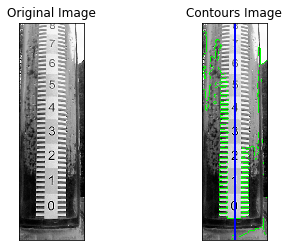

151819.5
42301 42301 18
42301
水表轮廓为：


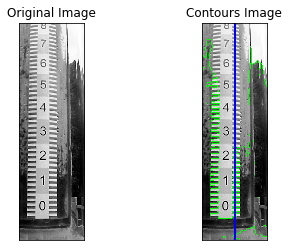

150598.0
22105
水表轮廓为：


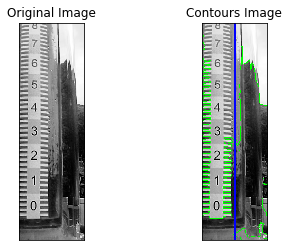

154143.5
15534
水表轮廓为：


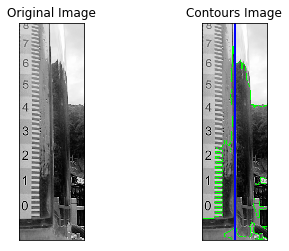

149696.0
水表轮廓为：


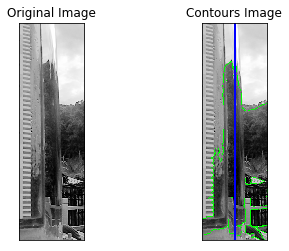

138282.5
水表轮廓为：


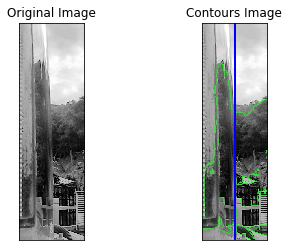

126077.0
水表轮廓为：


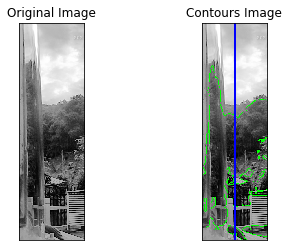

116985.0
水表轮廓为：


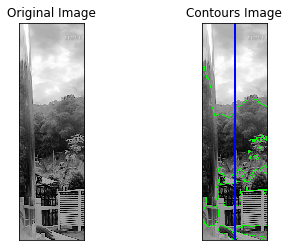

111563.5
水表轮廓为：


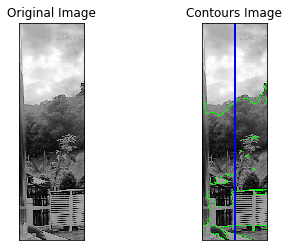

112171.0
水表轮廓为：


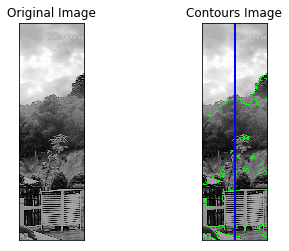

107128.0
水表轮廓为：


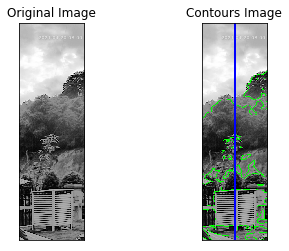

105841.5
水表轮廓为：


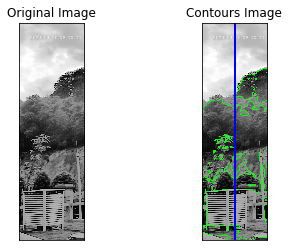

99537.5
水表轮廓为：


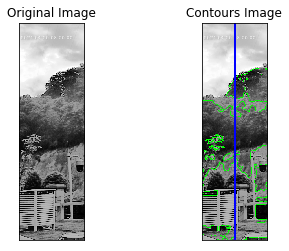

95874.0
水表轮廓为：


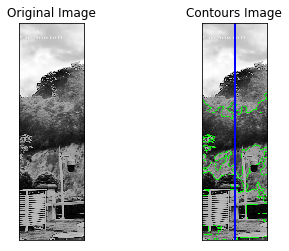

117796.5
水表轮廓为：


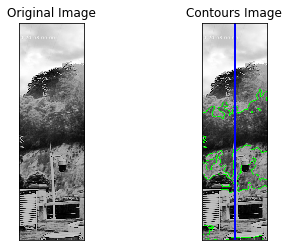

115720.5
水表轮廓为：


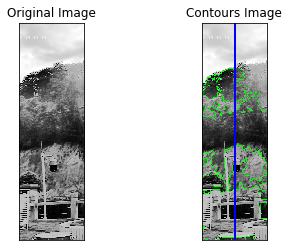

94894.5
水表轮廓为：


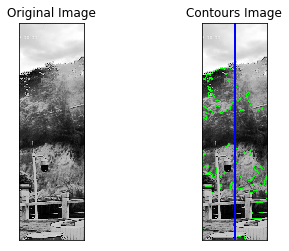

97464.5
水表轮廓为：


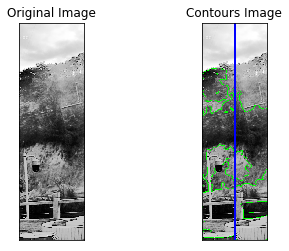

100250.0
水表轮廓为：


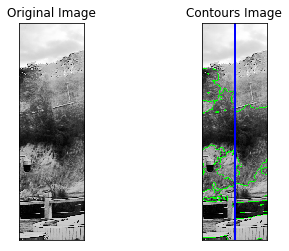

99642.5
水表轮廓为：


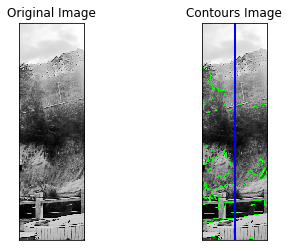

104849.0
水表轮廓为：


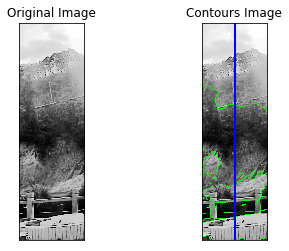

109874.0
水表轮廓为：


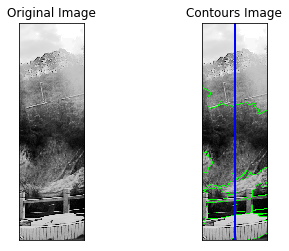

113192.0
18
水表轮廓为：


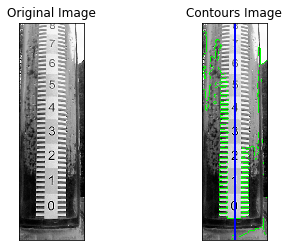

In [219]:
path = "sample7.jpg"

img = cv2.imread(path,0)
high = len(img)
wid = img[0].size

windowSize = 40
# 创建 Dynamic Window
windowNum = int((wid - 300) / windowSize)

maxSym = 0
maxWindow = 0
# 进行动态取样
for i in range(0, windowNum):
    bias = i * windowSize
    aim = img[0:1000, bias:bias+300]
    
#     print("分割后图片为：")
#     plt.imshow(aim,cmap = 'gray')
#     plt.show()

    equ, contour = preProcess(aim, "none")
    
    # ================= 计算当前图例中最大轮廓面积 =======================
    maxA = 0
    maxIn = 0
    for j in range(0, len(contour)):
        arr = contour[j]
        # M = cv2.moments(arr)
        area = cv2.contourArea(arr)
        if area > maxA:
            maxA = area
            maxIn = j
       
    print(maxA)
    if maxA < 150000:
        continue
        
    # ================= 划分左右轮廓 =================
    midWid = wid / 2
    
    leftContour = []
    rightContour = []
    
    for arr in contour[maxIn]:
        if arr[0, 0] <= 150:
            leftContour.append(arr)
        else:
            rightContour.append(arr)
            
    # 按照高度排序
    leftContour.sort(key=takeSecond)
    rightContour.sort(key=takeSecond)
    # print(leftContour)
    
    leftPos = 0
    leftSize = len(leftContour)
    
    rightPos = 0
    rightSize = len(rightContour)
    
    # 找出左右连续线段
#     leftBlock = []
#     for w in range(0, 200):
#         w2 = w * 5
#         block = []
#         while (leftPos < leftSize and leftContour[leftPos][0, 1] < w2 + 5):
#             if leftContour[leftPos][0, 1] >= w2:
#                 block.append(leftContour[leftPos])
#             leftPos += 1
            
#         conNum = 0
#         maxConLen = 0
#         pre = 0
#         block.sort(key=takeFirst)
#         for arr in block:
#             if (arr[0, 0] - pre) < 5:
#                 conNum += 1
#                 maxConLen = max(maxConLen, conNum)
#             else:
#                 conNum = 0
#             pre = arr[0, 0]
            
#         if maxConLen > 15:
#         # if len(block) > 4:
#             leftBlock.append(block)
#         if (leftPos >= leftSize):
#             break
    
#     rightBlock = []
#     for w in range(0, 200):
#         w2 = w * 5
#         block = []
#         while (rightPos < rightSize and rightContour[rightPos][0, 1] < w2 + 5):
#             if rightContour[rightPos][0, 1] >= w2:
#                 block.append(rightContour[rightPos])
#             rightPos += 1
        
#         conNum = 0
#         maxConLen = 0
#         pre = 0
#         block.sort(key=takeFirst)
#         for arr in block:
#             if (arr[0, 0] - pre) < 5:
#                 conNum += 1
#                 maxConLen = max(maxConLen, conNum)
#             else:
#                 conNum = 0
#             pre = arr[0, 0]
            
#         if maxConLen > 15:
#             rightBlock.append(block)
#         if (rightPos >= rightSize):
#             break
            
#     print(len(leftBlock), len(rightBlock))
#     symNum = min(len(leftBlock), len(rightBlock))
    
#     # 计算对称点数量
    symNum = 0
    for a1 in range(0, leftSize):
        for a2 in range(0, rightSize):
             if abs(leftContour[a1][0, 1] - rightContour[a2][0, 1]) < 3:
                    if abs(abs(leftContour[a1][0, 0] - 150) - abs(rightContour[a2][0, 0] - 150)) < 30:
                        symNum += 1
#     leftPos = 0
#     rightPos = 0
#     while leftPos < leftSize and rightPos < rightSize :
#         if abs(leftContour[leftPos][0, 1] - rightContour[rightPos][0, 1]) < 10:
#             if abs(leftContour[leftPos][0, 0] - 150) < 20 and abs(rightContour[rightPos][0, 0] - 150) < 20:
#                 # print(leftContour[leftPos], ":", rightContour[rightPos])
#                 symNum += 1   
#         if (leftContour[leftPos][0, 1] < rightContour[rightPos][0, 1]):
#             leftPos += 1
#         else:
#             rightPos += 1
    
    if symNum > maxSym:
        maxSym = symNum
        maxWindow = i
        print(maxSym, symNum, i)
        
    # ================= 计算左右轮廓面积 =================    
    # leftContour = np.array(leftContour)
    # rightContour = np.array(rightContour)
    # leftArea = cv2.contourArea(leftContour)
    # rightArea = cv2.contourArea(rightContour)
    print(symNum)
    
    # ================= 绘制最小外接矩形 =================
    # max_rect = cv2.minAreaRect(contour[maxIn])
    # max_box = cv2.boxPoints(max_rect)
    # max_box = np.int0(max_box)

print(maxWindow)
bias = maxWindow * windowSize
aim = img[:1000, bias:bias+300]
equ, contour = preProcess(aim)